In [10]:
from tqdm import tqdm
import math
from pathlib import Path
from fastai import *
from fastai.vision.all import *
from fastai.data.all import *
from pathlib import Path
from PIL import Image
import math

In [2]:
import warnings
import os
import numpy as np
import torch

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
data_path = Path('./data/new_crops/')

In [28]:
fns = get_image_files(data_path)

In [29]:
failed = verify_images(fns)

In [30]:
failed

(#0) []

In [13]:
#failed.map(Path.unlink);

In [31]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

In [32]:
dls = db.dataloaders(data_path)

/home/21rfk/project/mtcnn-pytorch/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [33]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

SuggestedLRs(valley=0.00363078061491251)

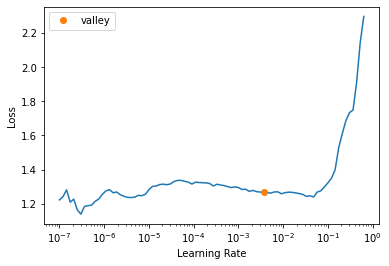

In [17]:
learn.lr_find()

In [38]:
lr = 3e-3
learn = cnn_learner(dls, resnet18, metrics=accuracy, lr=lr)
learn.fine_tune(2, freeze_epochs=6)

epoch,train_loss,valid_loss,accuracy,time
0,1.289555,0.847307,0.533849,00:04
1,1.182469,0.845355,0.558994,00:04
2,1.132558,0.798843,0.615087,00:04
3,1.056432,0.818400,0.626692,00:04
4,0.966829,0.723089,0.624758,00:04
5,0.880592,0.722565,0.626692,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.700404,0.731853,0.626692,00:04
1,0.665458,0.689781,0.663443,00:04


In [17]:
dls.train

In [39]:
train_loss, train_accuracy = learn.validate(dl=dls.train)
train_accuracy

0.7294921875

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

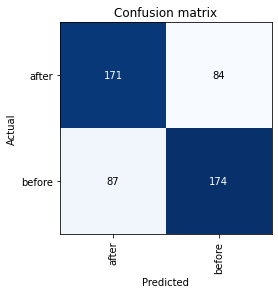

In [20]:
interp.plot_confusion_matrix()

In [40]:
learn.model_dir = "saved_model"
learn.export("./saved_model/before_after.pkl")

In [41]:
from fastai.learner import *

In [4]:
learn_inf = load_learner("saved_model/before_after.pkl")

In [5]:
from IPython.display import display

In [11]:
def predict(fn, scale=1):
    sample_dir = Path("./sample_images")
    path = sample_dir / fn
    
    img = Image.open(path)
    img = img.resize((math.floor(img.shape[1] * scale), math.floor(img.shape[0] * scale)))
    display(img)
    return learn_inf.predict(img)